## 3. CNN models

This method trains convolutional neural networks using either individual pixel feature values (`Conv1D`) or resized field images (`Conv2D`).

In [2]:
#Run this cell to automatically reload all modules (if they've been externally edited)
%load_ext autoreload
%autoreload 2

In [3]:
#Run this cell to silence warnings (not recommended!)
#Used here to silence tensorflow deprecation warnings
import warnings
warnings.simplefilter('ignore')

### Load custom modules

In [17]:
from modules.process_data import SelectFeatures, Scale, OneHot
from modules.run_models import ModelEnsemble, make_submission
from modules.metaclassifiers import UnweightedAverage

### Load python modules

In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
import pickle

In [4]:
from tensorflow import keras
from sklearn.metrics import log_loss

### Load processed feature datasets

In [9]:
train_data = pd.read_pickle('extracted_data/train_data.pkl')
expanded_pixels_train = pd.read_pickle('processed_data/train/expanded_pixels.pkl')
resized_images_train = np.load('processed_data/train/resized_images.npy')


test_data = pd.read_pickle('extracted_data/test_data.pkl')
expanded_pixels_test = pd.read_pickle('processed_data/test/expanded_pixels.pkl')
resized_images_test = np.load('processed_data/test/resized_images.npy')

### Split fields into train and validation sets

Note: This is not required for the ensemble models as this is performed automatically in the two-fold classifier fitting method of `ModelEnsemble`.

In [10]:
def train_test_split(data, random_state = 42):
    
    fields = data['Field_Id'].unique().tolist()
    
    from sklearn.model_selection import train_test_split
    
    train_fields, test_fields = train_test_split(fields, random_state = random_state)

    return train_fields, test_fields

In [11]:
train_fields, test_fields = train_test_split(train_data)

## Conv1D

### Select features

Select pixel values for each spectral band (B01-B12) as well as the NDVI vegetative index.

In [12]:
sf = SelectFeatures(keep_cols = ['NDVI', 'B'],
                    drop_cols = ['Field_Id', 'Crop_Id_Ne', 'ARVI', 'WIN', 'SPR', 'SUM', 'AUT'])

fit_A = sf.transform([expanded_pixels_train])
predict_A = sf.transform([expanded_pixels_test])

Selected  55  columns 
Use .cols attribute to see all columns

Selected  55  columns 
Use .cols attribute to see all columns



### Pre-process features

* Min-Max scale all numerical features

In [22]:
sc = Scale(keep_cols=['B', 'NDVI']).fit(fit_A)

fit_A = sc.transform(fit_A)

Scaling  55  columns 
Use .cols attribute to see all columns



* Fill NaN with their mean column values

In [30]:
fit_A = fit_A.fillna(fit_A.mean())

In [23]:
fit_A.head()

,Field_Id,0210_NDVI,0312_NDVI,0620_NDVI,0715_NDVI,0804_NDVI,0101_NDVI,0322_NDVI,0819_NDVI,0131_NDVI,...,0715_B04,0531_B08,0131_B03,0322_B08,0819_B04,0131_B02,0804_B08,0819_B03,0819_B02,0131_B04
0,1,0.841744,0.589831,0.324161,0.469348,0.331503,0.628437,0.597858,0.427764,0.731256,...,0.259259,0.285886,0.201850,0.424765,0.367452,0.126292,0.219727,0.316017,0.288549,0.148074
1,1,0.862234,0.575354,0.301155,0.450977,0.317423,0.674327,0.637323,0.424661,0.784243,...,0.275421,0.288689,0.181175,0.450739,0.373264,0.117681,0.223374,0.326599,0.293651,0.121273
2,1,0.895746,0.622939,0.302289,0.444324,0.300892,0.732084,0.689770,0.433262,0.826746,...,0.276431,0.299299,0.156148,0.482759,0.363901,0.088404,0.221838,0.329485,0.302154,0.098827
3,1,0.915159,0.702329,0.302855,0.468479,0.344428,0.801237,0.744408,0.459658,0.844468,...,0.275421,0.302703,0.135473,0.501343,0.351954,0.083238,0.250048,0.316498,0.297619,0.088777
4,1,0.929408,0.769369,0.303651,0.466787,0.355469,0.834417,0.798120,0.459253,0.875937,...,0.286195,0.308108,0.139826,0.532468,0.353891,0.078071,0.260027,0.316017,0.299887,0.071357


### Split data and reshape into 1D arrays

In [108]:
#Split 'fit' data into train and validation sets
X_train = fit_A[fit_A['Field_Id'].isin(train_fields)].drop('Field_Id', axis = 1)
X_test = fit_A[fit_A['Field_Id'].isin(test_fields)].drop('Field_Id', axis = 1)

y_train = expanded_pixels_train['Crop_Id_Ne'][expanded_pixels_train['Field_Id'].isin(train_fields)]
y_test = expanded_pixels_train['Crop_Id_Ne'][expanded_pixels_train['Field_Id'].isin(test_fields)]

y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

In [109]:
#Sort columns into date order
X_train = X_train[X_train.columns.sort_values()]
X_test = X_test[X_test.columns.sort_values()]

In [110]:
#Reshape into n_samples*55x1 pixel arrays
X_train_res = np.array([np.reshape(np.array(x), (55,1)) for x in X_train.values.tolist()])
X_test_res = np.array([np.reshape(np.array(x), (55,1)) for x in X_test.values.tolist()])

In [111]:
X_train_res.shape, X_test_res.shape, y_train.shape, y_test.shape

((362290, 55, 1), (114420, 55, 1), (362290, 9), (114420, 9))

### Build and run CNN

In [117]:
learning_rate = 0.001
epochs = 20
batch_size = 50000

In [118]:
model = keras.models.Sequential()

model.add(keras.layers.Conv1D(32, 
                            kernel_size=(6),
                            activation='relu',
                            strides = 1))

model.add(keras.layers.MaxPooling1D(pool_size=(2)))

model.add(keras.layers.Conv1D(64, 
                            kernel_size=(2),
                            activation='relu'))

model.add(keras.layers.MaxPooling1D(pool_size=(2)))


#model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(1000, activation='relu'))

model.add(keras.layers.Dense(512, activation='relu'))

model.add(keras.layers.Dense(128, activation='relu'))
          
#model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(9, activation='softmax'))

In [119]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

In [115]:
history = model.fit(X_train_res, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test_res,y_test))

Train on 362290 samples, validate on 114420 samples
Epoch 1/100
362290/362290 [==============================] - 97s 268us/sample - loss: 1.9514 - acc: 0.4017 - val_loss: 1.6704 - val_acc: 0.4489
Epoch 2/100
362290/362290 [==============================] - 72s 198us/sample - loss: 1.6087 - acc: 0.4801 - val_loss: 1.5238 - val_acc: 0.4536
Epoch 3/100
362290/362290 [==============================] - 69s 189us/sample - loss: 1.4806 - acc: 0.5026 - val_loss: 1.3947 - val_acc: 0.5175
Epoch 4/100
362290/362290 [==============================] - 69s 191us/sample - loss: 1.3662 - acc: 0.5538 - val_loss: 1.2727 - val_acc: 0.6197
Epoch 5/100
362290/362290 [==============================] - 71s 195us/sample - loss: 1.2687 - acc: 0.5891 - val_loss: 1.2116 - val_acc: 0.6316
Epoch 6/100
362290/362290 [==============================] - 69s 189us/sample - loss: 1.2089 - acc: 0.6008 - val_loss: 1.1174 - val_acc: 0.6529
Epoch 7/100
362290/362290 [==============================] - 74s 205us/sample - loss

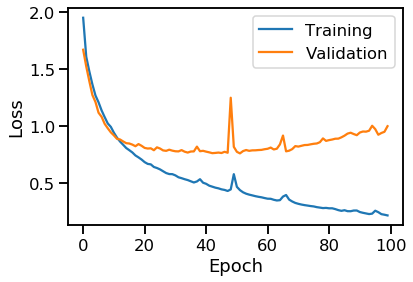

In [116]:
#Plot learning curve

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("talk")

plt.plot(history.history['loss'], label="Training")
plt.plot(history.history['val_loss'], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Conv2D

Use the resized image features (pickled as numpy arrays) and transpose such that tensor is 4D with shape `(batch, rows, cols, channels)` where `batch = 2494` training samples, `rows = 32`, `cols = 32` and `channels = 285` - comprising all spectral band images at each time frame, as well as all vegetative index images and time difference images. Select only the first 110 channels to improve training speed, this may be modified in the future.

In [26]:
fit_B = resized_images_train.transpose(0, 2, 3, 1)

In [27]:
fit_B.shape

(2494, 32, 32, 285)

In [28]:
fit_B = fit_B[:,:,:,:110]

In [29]:
#Split 'fit' data into train and validation sets

X_train = fit_B[train_data['Field_Id'].isin(train_fields)]
X_test = fit_B[train_data['Field_Id'].isin(test_fields)]

y_train = train_data['Crop_Id_Ne'][train_data['Field_Id'].isin(train_fields)]
y_test = train_data['Crop_Id_Ne'][train_data['Field_Id'].isin(test_fields)]

y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

In [78]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1870, 32, 32, 110), (624, 32, 32, 110), (1870, 9), (624, 9))

In [94]:
img_size = (32,32,110)
learning_rate = 0.001
epochs = 50
batch_size = 500

In [100]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=img_size))

model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))

model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

#model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(1000, activation='relu'))

model.add(keras.layers.Dense(512, activation='relu'))

model.add(keras.layers.Dense(128, activation='relu'))

#model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(9, activation='softmax'))

In [101]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

In [102]:
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test,y_test))

Train on 1870 samples, validate on 624 samples
Epoch 1/50
1870/1870 [==============================] - 13s 7ms/sample - loss: 2.0553 - acc: 0.2781 - val_loss: 1.7966 - val_acc: 0.3654
Epoch 2/50
1870/1870 [==============================] - 11s 6ms/sample - loss: 1.8224 - acc: 0.3813 - val_loss: 1.7881 - val_acc: 0.3654
Epoch 3/50
1870/1870 [==============================] - 11s 6ms/sample - loss: 1.7567 - acc: 0.4348 - val_loss: 1.6673 - val_acc: 0.4663
Epoch 4/50
1870/1870 [==============================] - 11s 6ms/sample - loss: 1.6551 - acc: 0.4893 - val_loss: 1.5746 - val_acc: 0.4904
Epoch 5/50
1870/1870 [==============================] - 11s 6ms/sample - loss: 1.5688 - acc: 0.5064 - val_loss: 1.5450 - val_acc: 0.4984
Epoch 6/50
1870/1870 [==============================] - 12s 7ms/sample - loss: 1.5371 - acc: 0.5080 - val_loss: 1.5137 - val_acc: 0.5032
Epoch 7/50
1870/1870 [==============================] - 14s 7ms/sample - loss: 1.4963 - acc: 0.5203 - val_loss: 1.5032 - val_acc: 0

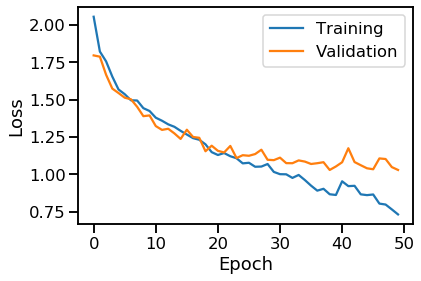

In [103]:
#Plot learning curve

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("talk")

plt.plot(history.history['loss'], label="Training")
plt.plot(history.history['val_loss'], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()